# Chapter 10 Deep Learning for TimeSeries

## 10.1 Different kinds of timeseries tasks

Working with timeseries involves understanding the $dynamics$
 $of$ $a$ $system$—its periodic cycles, how it trends over time, its regular regime and its
 sudden spikes.

By far, the most common timeseries-related task is $forecasting$: predicting what will
 happen next in a series

Three typical problems:

1. $Classification$—Assign one or more categorical labels to a timeseries. For instance,
given the timeseries of the activity of a visitor on a website, classify whether the
visitor is a bot or a human.

2. $Event$ $detection$—Identify the occurrence of a specific expected event within a
continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok
Google” or “Hey Alexa.”


3. $Anomaly$ $detection$ —Detect anything unusual happening within a continuous
datastream. Unusual activity on your corporate network? Might be an attacker.
Unusual readings on a manufacturing line? Time for a human to go take a look.
Anomaly detection is typically done via unsupervised learning, because you
often don’t know what kind of anomaly you’re looking for, so you can’t train on
specific anomaly examples.

## 10.2 A Temperature-Forecasting Example

We’ll work with a weather timeseries dataset recorded at the weather station at the
 Max Planck Institute for Biogeochemistry in Jena, Germany

__14__ different quantities (such as temperature, pressure, humidity, wind direction, and so on)
 were recorded __every 10 minutes__ over several years.

 https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip


Listing 10.1 Inspecting the data of the Jena weather dataset

In [1]:
import os 
fname = os.path.join("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we
will use to predict future temperatures. 

Note that we discard the “Date Time” column

Listing 10.2 Parsing the data

In [2]:
import numpy as np 

temperature = np.zeros((len(lines),))

raw_data = np.zeros(  (len(lines),len(header)-1 ) )

for i, line in enumerate(lines):
    ## From index = 1 is because we discard the "Date Time": index0 
    values = [float(x) for x in line.split(",")[1:]  ]
    temperature[i] = values[1]

    # We stall all columns (without data time but include temperature in raw_data)
    raw_data[i,:] = values[:]

Listing 10.3 Plotting the temperature timeseries

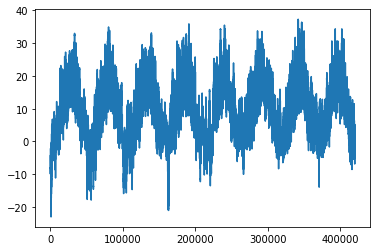

In [3]:
from matplotlib import pyplot as plt

plt.plot( range(len(temperature)),temperature)

Figure 10.2 shows a more narrow plot of the first 10 days of temperature data. Because
the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day.

Listing 10.4 Plotting the first 10 days of the temperature timeseries

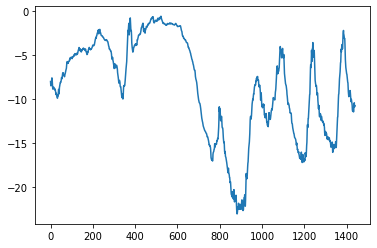

In [4]:
plt.plot(range(1440),temperature[:1440])
plt.show()

On this plot, you can see daily periodicity, especially for the last 4 days. Also note that
this 10-day period must be coming from a fairly cold winter month.

#### Always look for periodicity in your data

Periodicity over multiple timescales is an important and very common property of
timeseries data. 

Whether you’re looking at the weather, mall parking occupancy, traffic to a website, sales of a grocery store, or steps logged in a fitness tracker, you’ll
see daily cycles and yearly cycles (human-generated data also tends to feature
weekly cycles). 

When exploring your data, make sure to look for these patterns.

With our dataset, if you were trying to __predict average temperature for the next month__
 given a few months of past data.

With a question in mind : Is timeseries predictable at a daily scale?

In all our experiments, we’ll use the __first 50% of the data for training__, the __following 25% for validation__, and the __last 25% for testing.__

Listing 10.5 Computing the number of samples we’ll use for each data split

In [5]:
num_train_samples  =  int( 0.5*len(raw_data)  )
num_val_samples  =  int( 0.25*len(raw_data)  )
num_test_samples  =  int( len(raw_data)-num_train_samples-num_val_samples )

print("Number of train samples {}".format(num_train_samples))
print("Number of val samples {}".format(num_val_samples))
print("Number of test samples {}".format(num_test_samples))

Number of train samples 210225
Number of val samples 105112
Number of test samples 105114


### 10.2.1 Preparing the Data

First, let’s preprocess the data to a format a neural network can ingest. This is
 easy: the data is already numerical, so you don’t need to do any vectorization.

We’ll normalize each timeseries independently so that they all
 take small values on a similar scale. 

We’re going to use the first 210,225 timesteps as
 training data, so we’ll compute the mean and standard deviation only on this fraction of the data

Listing 10.6 Normalizing the data

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis= 0)
raw_data /= std

Next, let’s create a Dataset object that yields ___batches of data from the past Five days
 along with a target temperature 24 hours in the future___.

Because the samples in the
 dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to __explicitly allocate memory for every sample__.

In Keras that does just that __timeseries_dataset_from_array()__, so we can
 save ourselves some work by using it. You can generally use it for any kind of timeseries
 forecasting task.

#### Understanding timeseries_dataset_from_array()

The general idea is that you provide an array of timeseries data (the
 data argument), and timeseries_dataset_from_array() __gives you windows
 extracted from the original timeseries__ (we’ll call them “sequences”).

Examples : 

1.  __data = [0 1 2 3 4 5 6]__ and __sequence_length=3__, then
timeseries_dataset_from_array() will generate the following samples: [0 1 2],
[1 2 3], [2 3 4], [3 4 5], [4 5 6].

2. You can also pass a __targets__ argument (an array) to timeseries_dataset_
from_array(). The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you’re
doing timeseries forecasting, __targets should be the same array as data, offset
by some amount__

    For instance, with data = [0 1 2 3 4 5 6 …] and sequence_length=3, you could create
a dataset to predict the next step in the series by passing targets = [3 4 5 6 …]. Let’s
try it

In [7]:
from tensorflow import keras
from keras.utils import timeseries_dataset_from_array


In [8]:
int_sequence = np.arange(10)

dummy_dataset = timeseries_dataset_from_array(

    #data = [0,1,2,3,4,5,6]
    
    data= int_sequence[:-3],
    # The target for the sequence that 
# starts at data[N] will be data[N + 3]
    targets= int_sequence[3:],

    #     The sequences will 
    # be 3 steps long.
    sequence_length=3,

    # The sequences will be 
    # batched in batches of size 2.
    batch_size=2,
)

print(dummy_dataset)

for inputs ,targtes in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targtes[i]) )


<BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for
training, one for validation, and one for testing.
 We’ll use the following parameter values:

1. __sampling_rate = 6__ —Observations will be sampled at one data point per hour:
we will only keep one data point out of 6.


2. __sequence_length = 120__  —Observations will go back 5 days (120 hours).


3. __delay = sampling_rate * (sequence_length + 24 - 1)__ —The target for a sequence
will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass __start_index = 0 and end_index =
num_train_samples__ to only use the first 50% of the data. 

For the validation dataset,
we’ll pass start_index = num_train_samples and end_index = num_train_samples +
num_val_samples to use the next 25% of the data. 

Finally, for the test dataset, we’ll pass
start_index = num_train_samples + num_val_samples to use the remaining samples.

Listing 10.7 Instantiating datasets for training, validation, and testing

In [9]:
sampling_rate = 6
sequence_length = 120

## 5days ==> Next temperature
delay = sampling_rate*(sequence_length+24-1)
batch_size = 256

In [10]:
raw_data.shape

(420451, 14)

In [11]:
train_dataset = timeseries_dataset_from_array(
    data= raw_data[:-delay],
    targets= temperature[delay:],
    sampling_rate= sampling_rate,
    sequence_length= sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = timeseries_dataset_from_array(
    data= raw_data[:-delay],
    targets= temperature[delay:],
    sampling_rate= sampling_rate,
    sequence_length= sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)


test_dataset = timeseries_dataset_from_array(
    data= raw_data[:-delay],
    targets= temperature[delay:],
    sampling_rate= sampling_rate,
    sequence_length= sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_val_samples+num_train_samples
    
)


Each dataset yields a __tuple (samples, targets)__, where __samples__ is __a batch of 256 samples__,


i.e num_samples = len(raw_data) // batch_size 

each sample in __samples__ containing __120 consecutive hours of input data__,

i.e [len(sample) for sample in samples] =  [120]

samples.shape = ( 256 , 120, 14  )

 and targets is the corresponding array of 256 target temperatures.

targets.shape = (256, 1 ,1)

Listing 10.8 Inspecting the output of one of our datasets

In [12]:
for samples , targets in train_dataset:
    print("samples shape {}".format(samples.shape))
    print("targets shape {}".format(targets.shape))
    break

samples shape (256, 120, 14)
targets shape (256,)


### 10.2.2 A common-sense, non-machine learning baseline

It will serve as a sanity
 check, and it will establish a baseline that we’ll have to beat in order to demonstrate
 the usefulness of more-advanced machine learning models.


In this case, the __temperature timeseries can safely be assumed to be continuous__
 (the temperatures tomorrow are likely to be close to the temperatures today) as
 well as periodical with a daily period. 
 
 Thus a common-sense approach is to always
 __predict that the temperature 24 hours from now will be equal to the temperature
 right now__ 
 
 Let’s evaluate this approach, using the __mean absolute error (MAE) metric__, defined as follows:
 
 
 np.mean(np.abs(preds - targets))

Listing 10.9 Computing the common-sense baseline MAE

In [13]:
def evaluate_naive_method(dataset):
    total_abs_error = 0.
    samples_seen = 0
    for samples,targets in dataset:
    
    # The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence. 
    # Recall that we normalized our features, so to retrieve a temperature in degrees Celsius, 
    # we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.

        preds = samples[:,-1,1]*std[1] + mean[1]
        total_abs_error += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]
    return total_abs_error/samples_seen

print("Validation MAE= {:.2f}".format( evaluate_naive_method(val_dataset) ))
print("Test MAE= {:.2f}".format( evaluate_naive_method(test_dataset) ))
        

KeyboardInterrupt: 

So if you always assume that the temperature 24
 hours in the future will be the same as it is now, you will be off by two and a hal 
 degrees on average. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic

### 10.2.3 Let’s try a basic machine learning model

+ This is the best way to make sure any
 further complexity you throw at the problem is legitimate and delivers real benefits

+ The following listing shows a fully connected model that starts by flattening the
 data and then runs it through two Dense layers.

+ Note the lack of an activation function
 on the last Dense layer, which is typical for a regression problem.

+ We use mean
 squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth
 around zero, which is a useful property for gradient descent

Listing 10.10 Training and evaluating a densely connected model

In [ ]:
from keras import layers


inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16,activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs = inputs,outputs = outputs)


In [ ]:
from keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint(
    filepath="E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_dense.keras",
        monitor="val_loss",
        save_best_only=True
) ]

model.compile(
            optimizer = keras.optimizers.RMSprop(),
            loss = keras.losses.MeanSquaredError(),
            metrics = ["mae"]
)


In [ ]:
history = model.fit(train_dataset,
                    callbacks = callbacks,
                    epochs = 10,
                    validation_data = val_dataset
)

Epoch 1/10
819/819 [==============================] - 15s 15ms/step - loss: 13.5454 - mae: 2.8422 - val_loss: 10.7003 - val_mae: 2.5820
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 9.3608 - mae: 2.4102 - val_loss: 10.7751 - val_mae: 2.5969
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 8.6645 - mae: 2.3183 - val_loss: 13.2215 - val_mae: 2.9021
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 8.2235 - mae: 2.2593 - val_loss: 13.0535 - val_mae: 2.8730
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 7.8995 - mae: 2.2161 - val_loss: 10.6825 - val_mae: 2.5827
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.6399 - mae: 2.1786 - val_loss: 12.4189 - val_mae: 2.8046
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 7.4614 - mae: 2.1528 - val_loss: 11.1000 - val_mae: 2.6361
Epoch 8/10
819/819 [==============================] - 

In [ ]:
from keras import models 
model= models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_dense.keras")
print("The Test MAE = {}".format(model.evaluate(test_dataset)[1]))

405/405 [==============================] - 4s 8ms/step - loss: 11.3478 - mae: 2.6310
The Test MAE = 2.630976676940918


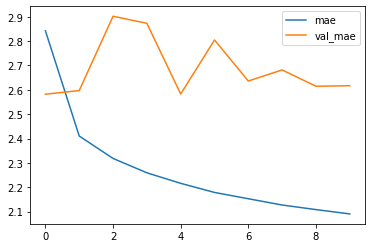

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history["mae"].plot()
df_history["val_mae"].plot()
plt.legend()

+ Some of the validation losses are close to the no-learning baseline, but not reliably.
 This goes to show the merit of having this baseline in the first place: it turns out to be
 not easy to outperform.

+ Well, the space of models in which you’re searching for a solution—
 that is, your hypothesis space—is the space of all possible two-layer networks with the
 configuration you defined.

+ Just because a good solution technically exists in your hypothesis space doesn’t mean
 you’ll be able to find it via gradient descent.

+ unless the
 learning algorithm is hardcoded to look for a specific kind of simple model, it can
 sometimes fail to find a simple solution to a simple problem.

### 10.2.4 Let’s try a 1D convolutional model

A temporal convnet
 could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image

The __Conv1D__ layer
 relies on __1D windows that slide__ across input sequences, and the __Conv3D__ layer relies on
 __cubic windows__ that slide across input volumes.

You can thus build 1D convnets, strictly analogous to 2D convnets. 

They’re a great
fit for any sequence data that follows the $translation$ $invariance$ $assumption$

 __if you slide a window over the sequence, the content of the window should follow
the same properties independently of the location of the window__).

Let’s try one on our temperature-forecasting problem. We’ll pick an initial window
 length of 24, so that we look at 24 hours of data at a time.

  As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly:

In [ ]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Conv1D(8,24,activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,12,activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,6,activation='relu')(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)



In [ ]:
callbacks = [ModelCheckpoint(
    filepath="E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_conv.keras",
        monitor="val_loss",
        save_best_only=True
) ]

model.compile(
            optimizer = keras.optimizers.RMSprop(),
            loss = keras.losses.MeanSquaredError(),
            metrics = ["mae"]
)


In [ ]:
history = model.fit(train_dataset,
                    callbacks = callbacks,
                    epochs = 10,
                    validation_data = val_dataset,
                    verbose = 0
)

In [ ]:
model= models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_conv.keras")
print("The Test MAE = {}".format(model.evaluate(test_dataset)[1]))

405/405 [==============================] - 4s 9ms/step - loss: 21.3965 - mae: 3.6597
The Test MAE = 3.6597049236297607


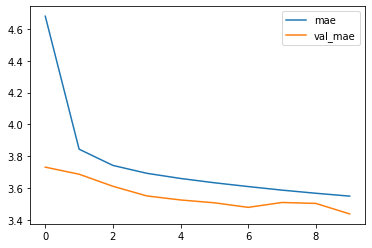

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history["mae"].plot()
df_history["val_mae"].plot()
plt.legend()

As it turns out, this model performs even worse than the densely connected one.

1.  First, weather data __doesn’t quite respect the translation invariance assumption__.Weather
 data is only translation-invariant for a very specific timescale.


2.  Second, order in our data matters—a lot. __The recent past is far more informative for predicting the next day’s temperature than data from five days ago.__ 
A 1D convnet is not able to leverage this fact. __In particular, our max pooling and
 global average pooling layers are largely destroying order information.__

### 10.2.5 A first recurrent baseline

+ The densely connected approach first __flattened the timeseries__, which removed the notion of time
 from the input data. 
 
 
+ The convolutional approach treated every segment of the data in
 the same way, even applying pooling, which __destroyed order information__.

So we have to introduce the recurrent neural networks

Among them, the __Long Short Term Memory (LSTM)__
 layer has long been very popular. We’ll see in a minute how these models work, but
 let’s start by giving the LSTM layer a try

Listing 10.12 A simple LSTM-based model

In [ ]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint(filepath="E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_lstm.keras",
 save_best_only=True) ]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks,verbose = 0)

In [ ]:
model= models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Ch10_Weather_Forecast\\jena_lstm.keras")
print("The Test MAE = {}".format(model.evaluate(test_dataset)[1]))

405/405 [==============================] - 6s 12ms/step - loss: 10.8920 - mae: 2.5814
The Test MAE = 2.5813724994659424


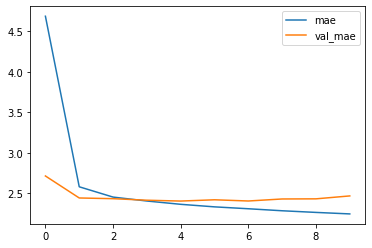

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history["mae"].plot()
df_history["val_mae"].plot()
plt.legend()

It's much better !

## 10.3 Understanding Recurrent Neural Networks

For  Dense and CNN : __Have NO memory__ 
+  With such networks, in order to process a sequence or a temporal series of data points, you have to
 show the entire sequence to the network at once

+  Such networks are called $feedforward$ networks.

A $recurrent$ $neural$ $network$ (RNN) adopts the same principle, albeit in an extremely simplified version: 


it processes $sequences$ by __iterating__ through the sequence elements and
__maintaining a state__ that contains information relative to what
it has seen so far


A simple, pesudocode RNN: 

This RNN takes as input a sequence of vectors, which we’ll encode as a rank-2
 tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t and the input at t (of shape (input_features,),
 and combines them to obtain the output at t.

For the first timestep, the previous output isn’t defined;
 hence, there is no current state. So we’ll initialize the state as an all-zero vector called
 the initial state of the network

Listing 10.13 Pseudocode RNN

In [ ]:
# state_t = 0 
# for input_t in input_sequence:
#     output_t = f(input_t,state_t)
#     state_t = output_t


Listing 10.14 More-detailed pseudocode for the RNN

In [ ]:
# state_t = 0 
# for input_t in input_sequence:
#     output_t = activation( dot(W,input_t) + dot(U,state_t) + b)
#     state_t = output_t


You can even flesh out the function __f__: 

the transformation of the input and state into an
output will be parameterized by two matrices, __W__ and __U__, and a __bias vector__. 

It’s similar to
the transformation operated by a densely connected layer in a feedforward network.

Listing 10.15 NumPy implementation of a simple RNN

In [ ]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps,input_features))

# Initial state: 
# an all-zero vector
state_t = np.zeros((output_features,))

W = np.random.random((output_features,input_features))
U = np.random.random((output_features,input_features))
b = np.random.random((output_features,))

successive_outputs =[]

# input_t is a vector of shape 
# (input_features,).
for input_t in  inputs: 
#     Combines the input with the current state (the previous 
# output) to obtain the current output. We use tanh to add 
# non-linearity (we could use any other activation function)
    output_t = np.tanh(  W.dot(input_t) + U.dot(input_t) + b  )


#     Updates the state of the
# network for the next timestep
    successive_outputs.append(output_t)

    state_t = output_t


#     The final output is a rank-2
# tensor of shape (timesteps,
# output_features).
final_output_sequence = np.stack(successive_outputs,axis=0)

final_output_sequence.shape

(100, 64)

__In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop__

####NOTE 

In this example, the final output is a rank-2 tensor of shape __(timesteps, output_features)__, where each timestep is the output of the loop at time __t__. 

Each timestep __t__ in the output tensor contains information about __timesteps 0 to t in the input sequence—about the entire past__. 

For this reason, in many cases, you don’t need this full sequence of outputs; you just need the
last output __(output_t at the end of the loop)__, because it already contains
information about the entire sequence.

### 10.3.1 A Recurrent Layer in Keras

The RNN we implemented before is the __simpleRNN__ layer

There is one minor difference: __SimpleRNN processes batches of sequences, like all
 other Keras layers, not a single sequence as in the NumPy example__
 
 This means it __takes
 inputs of shape (batch_size, timesteps, input_features), rather than (timesteps,
 input_features)__. 
 
 When specifying the shape argument of the initial Input(), note
 that __you can set the timesteps entry to None__, which enables your network to process
 sequences of arbitrary length.

Listing 10.16 An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None,num_features))
outputs = layers.SimpleRNN(16)(inputs)

This is especially useful if your model is meant to process sequences of variable length.
 
 
However, if all of your sequences have the same length, __I recommend specifying a
 complete input shape__, since it enables model.summary() to display output length
 information, which is always

All recurrent layers in Keras __SimpleRNN, LSTM, and GRU__ can be run in __two different modes__: 

1.  __Full__ sequences of successive outputs for each timestep (__a rank-3 tensor of shape (batch_size, timesteps, output_features)__)


2.  Return __only the last output__ for each input sequence (___a rank-2 tensor of shape (batch_
 size, output_features)__ )

These two modes are controlled by the __return_sequences__ constructor argument.

Listing 10.17 An RNN layer that returns only its last output step

In [ ]:
num_features =14 
steps = 120 
inputs = keras.Input(shape=(steps,num_features))
outputs = layers.SimpleRNN(16,return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


Listing 10.18 An RNN layer that returns its full output sequence

In [ ]:
num_features =14 
steps = 120 
inputs = keras.Input(shape=(steps,num_features))
outputs = layers.SimpleRNN(16,return_sequences=1)(inputs)
print(outputs.shape)

(None, 120, 16)


It’s sometimes useful to __stack__ several recurrent layers one after the other in order to
 increase the representational power of a network.

Listing 10.19 Stacking RNN layers

In [ ]:
inputs= keras.Input(shape=(steps,num_features))

x = layers.SimpleRNN(16,return_sequences=True)(inputs)
x = layers.SimpleRNN(16,return_sequences=True)(x)

outputs = layers.SimpleRNN(16)(x)

In such a setup, you have to get all
of the intermediate layers to return a full sequence of outputs

__SimpleRNN__

+ We will __rarely__ use __SimpleRNN__ in practise

+ In particular, __SimpleRNN__ has a major issue: although it should theoretically
 be able to retain at time t information about inputs seen many timesteps before, such
 __long-term dependencies prove impossible to learn in practice__.

+ This is due to the $vanishing$ $gradient$ problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: __as you keep adding layers to a
 network, the network eventually becomes untrainable.__

__LSTM__: 
+ It adds a way to carry information across many timesteps


+ It saves information for later, thus __preventing older signals from gradually vanishing during processing__.


+ Impact on the __cell ($c$)__: It will be combined with the input
 connection and the recurrent connection (via a dense transformation: a dot product
 with a weight matrix followed by a bias add and the application of an activation function), and it will __affect the state being sent to the next timestep__ (via an activation function and a multiplication operation).

__GRU__:
+  GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version o 
 the LSTM architecture.


Listing 10.20 Pseudocode details of the LSTM architecture

In [ ]:
# output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
# i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
# f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
# k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

Listing 10.21  Pseudocode details of the LSTM architecture (2/2)

$c_{t+1}$ = $i_t$ $\times$ $k_t$ + $c_t$ $\times$ $f_t$

These operations actually do is determined by the contents of the weights parameterizing
 them; and the weights are learned in an end-to-end fashion, starting over with each
 training round, making it __impossible to credit this or that operation with a specific
 purpose.__

In summary: 
+  you don’t need to understand anything about the specific architecture of an LSTM cell; as a human, it shouldn’t be your job to understand it. 

+ Just keep in mind what the __LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem__

## 10.4 Advanced use of recurrent neural networks

Next, we’ll review a number of more advanced features of RNNs, which can help you
get the most out of your deep learning sequence models. By the end of the section,
you’ll know most of what there is to know about using recurrent networks with Keras.
 We’ll cover the following:

1. $Recurrent$ $dropout$—This is a variant of dropout, used to fight overfitting in recurrent layers.

2. $Stacking$ $recurrent$ $layers$—This increases the representational power of the model
(at the cost of higher computational loads).

3. $Bidirectional$ $recurrent$ $layers$—These present the same information to a recurrent
network in different ways, increasing accuracy and mitigating forgetting issues.

### 10.4.1 Using recurrent dropout to fight overfitting

+  According to the Yarin's Thesis: __The same dropout mask__ (the same pattern of dropped units)
 __should be applied at every timestep__, instead of using a dropout mask that varies randomly from timestep to timestep

+  Using the __same dropout mask at every timestep
 allows the network to properly propagate its learning error through time__; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

+  Every recurrent layer in Keras has two dropout-related
 arguments: 
    1. __dropout__ : a float specifying the dropout rate for input units of the layer,
    2. __recurrent_dropout__, specifying the dropout rate of the recurrent units.

Listing 10.22 Training and evaluating a dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.LSTM(32,recurrent_dropout=0.25,unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs,outputs)

callbacks = [ModelCheckpoint(
    filepath="E:\Python-Machine-Learning\Deep_Learning_With_python\Ch10_Weather_Forecast\jena_lstm_dropout.keras",
    save_best_only=True
)]

model.compile(optimizer="rmsprop",loss='mse',metrics=['mae'])

history = model.fit(
                    train_dataset,
                    epochs = 1,
                    validation_data = val_dataset,
                    callbacks = callbacks,
                    verbose = 0
)

KeyboardInterrupt: 

In [ ]:
df_history = pd.DataFrame(history.history)
df_history["mae"].plot()
df_history["val_mae"].plot()
plt.legend()

#### RNN runtime performance


+  Recurrent models with very few parameters, like the ones in this chapter, __tend to
 be significantly faster on a multicore CPU than on GPU__, because they only involve
 small matrix multiplications, and the chain of multiplications is not well parallelizable due to the presence of a for loop. But larger RNNs can greatly benefit from a
 GPU runtime.

 +   As usual, cuDNN kernels are a mixed blessing: they’re fast, but inflexible—if you
 try to do anything not supported by the default kernel, you will suffer a dramatic slowdown, which more or less forces you to stick to what NVIDIA happens to provide

 +  As a way to speed up your RNN layer when you can’t use cuDNN, you can try __unrolling__
 it. Unrolling a for loop consists of removing the loop and simply inlining its content
 N times. In the case of the for loop of an RNN, __unrolling__ can help TensorFlow optimize the underlying computation graph.

    1. It will __Increase__ the __memory consumption__ of your RNN

    2. Can only do this if the number of timesteps in the data is known in advance by the model (that is to say, if
 you __pass a shape without any None entries to your initial Input()__)

### 10.4.2 Stacking recurrent layers

+ Should consider __increasing the capacity__ and expressive power of the network. As long as you aren’t overfitting too badly, you’re likely under capacity

+ Main Idea of __Stacking__: Increasing network capacity is typically done by __increasing the number of units in
 the layers or adding more layers__. Recurrent layer stacking is a classic way to build
 more-powerful recurrent networks

+ To stack recurrent layers on top of each other in Keras: __all intermediate layers__ should
 __return their full sequence of outputs (a rank-3 tensor)at the last timestep__. As you’ve already learned, this is done by specifying __return_sequences=True__

Listing 10.23 Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.GRU(32,recurrent_dropout=0.25,return_sequences=True)(inputs)
x = layers.GRU(32,recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs,outputs)

callbacks = [ModelCheckpoint(
    filepath="E:\Python-Machine-Learning\Deep_Learning_With_python\Ch10_Weather_Forecast\jena_lstm_stack.keras",
    save_best_only=True
)]

model.compile(optimizer="rmsprop",loss='mse',metrics=['mae'])

history = model.fit(
                    train_dataset,
                    epochs = 5,
                    validation_data = val_dataset,
                    callbacks = callbacks
)

Epoch 1/5
  6/819 [..............................] - ETA: 28:37 - loss: 148.9501 - mae: 10.1657

KeyboardInterrupt: 

In [ ]:
df_history = pd.DataFrame(history.history)
df_history["mae"].plot()
df_history["val_mae"].plot()
plt.legend()

### 10.4.3 Using bidirectional RNNs

A bidirectional
 RNN is a common RNN variant that can offer greater performance than a regular
 RNN on certain tasks. It’s frequently used in natural language processing—you could
 call it the Swiss Army knife of deep learning for natural language processing

__IDEA__: they process the timesteps of their __input
 sequences in order__, and __shuffling or reversing the timesteps__ can completely change
 the representations the RNN extracts from the sequence

Example: 
uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with,
 each of which processes the input sequence in one direction (chronologically and
 antichronologically), and then merges their representations.

All you need to
 do is write a variant of the data generator where the __input sequences are reverted along
 the time dimension__ (__replace the last line with yield samples[:, ::-1, :], targets)__.

The reversed-order LSTM strongly underperforms even the common-sense baseline,
 indicating that in this case, chronological processing is important to the success of the
 approach

 This makes perfect sense: the underlying LSTM layer will typically __be better
 at remembering the recent past than the distant past__, and naturally the more recent
 weather data points are more predictive than older data points for the problem

However, this __isn’t true for many other problems__, including natural language: intuitively, the importance of a word in understanding a sentence isn’t usually dependent on
 its position in the sentence.

Importantly, __an RNN trained on reversed sequences__ will learn __different representations__ than one trained on the original sequences, much as you would have different mental models if time flowed backward in the real world

In machine learning, representations that are $different$  yet $useful$ are always worth exploiting 

the  more they differ, the better: they offer a new angle from which to look at your data,

To instantiate a bidirectional RNN in Keras, you use the Bidirectional layer, which
 takes as its first argument a recurrent layer instance. 
 
 __Bidirectional()__ creates a second,separate instance of this recurrent layer and uses one instance for processing the
input sequences in __chronological order__ and the other instance for processing the
input sequences in __reversed order__

Listing 10.24 Training and evaluating a bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Bidirectional( layers.LSTM(16)(inputs) )
outputs = layers.Dense(1)(x)

model = keras.Model(inputs,outputs)

callbacks = [ModelCheckpoint(
    filepath="E:\Python-Machine-Learning\Deep_Learning_With_python\Ch10_Weather_Forecast\jena_lstm_bidirection.keras",
    save_best_only=True
)]

model.compile(optimizer="rmsprop",loss='mse',metrics=['mae'])

history = model.fit(
                    train_dataset,
                    epochs = 5,
                    validation_data = val_dataset,
                    callbacks = callbacks,
                    verbose = 0
)

In [ ]:
df_history = pd.DataFrame(history.history)
df_history["mae"].plot()
df_history["val_mae"].plot()
plt.legend()

All the predictive capacity must come from the chronological half of the
 network, because the antichronological half is known to be severely underperforming
 on this task (again, because the recent past matters much more than the distant past,
 in this case).
 
At the same time, the presence of the antichronological half doubles the
 network’s capacity and causes it to start overfitting much earlier

### 10.4.4 Going even Further


1. Adjust the number of units in each recurrent layer in the stacked setup, as well
as the amount of dropout. The current choices are largely arbitrary and thus
probably suboptimal.

2. Adjust the learning rate used by the RMSprop optimizer, or try a different
optimizer.

3. Try using a stack of Dense layers as the regressor on top of the recurrent layer,
instead of a single Dense layer.

4. Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.